# Anomaly/Outlier Detection

#### Tasks to perform
- Identify the top 1% outliers: adopt at least three different methods
from different families (e.g., density-based, angle-based…) and
compare the results.
- Visualize the outliers in a 2 or 3d scatter plot using at least one
dimensionality reduction technique.
- Deal with the outliers in a way you see fit, e.g. by removing them from
the dataset or by treating the anomalous variables as missing values
and employing replacement techniques. In this second case, you
should check that the outliers are not outliers anymore. Justify your
choices in every step.

In [139]:
#importing libraries
import pandas as pd
import numpy as np
from collections import Counter
from collections import defaultdict

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# data visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 300)

## Data Preparation for OD

In [140]:
path = 'data\data_full_upto_varThr.csv'
df = pd.read_csv(path)
print(len(df))
print(df.shape)
df.head()

2452
(2452, 123)


,vocal_channel,emotion,emotional_intensity,statement,repetition,sex,frame_count,sum,skew,lag1_kur,zc_sum,mfcc_sum,mfcc_mean,mfcc_max,mfcc_q05,mfcc_q25,mfcc_q50,mfcc_q75,mfcc_q95,mfcc_q99,sc_sum,sc_mean,sc_std,sc_min,sc_max,sc_q01,sc_q05,sc_q25,sc_q50,sc_q75,sc_q95,sc_q99,sc_kur,stft_sum,sum_w1,kur_w1,skew_w1,lag1_kur_w1,lag1_skew_w1,zc_sum_w1,zc_q95_w1,mfcc_sum_w1,mfcc_mean_w1,mfcc_std_w1,mfcc_max_w1,mfcc_q05_w1,mfcc_q25_w1,mfcc_q50_w1,mfcc_q75_w1,mfcc_q95_w1,mfcc_q99_w1,sc_sum_w1,sc_std_w1,sc_min_w1,sc_q25_w1,sc_q75_w1,sc_q95_w1,sc_kur_w1,sc_skew_w1,stft_sum_w1,stft_kur_w1,sum_w2,kur_w2,zc_sum_w2,mfcc_min_w2,mfcc_max_w2,mfcc_q75_w2,mfcc_q95_w2,mfcc_kur_w2,sc_sum_w2,sc_mean_w2,sc_std_w2,sc_min_w2,sc_max_w2,sc_q05_w2,sc_q25_w2,sc_q50_w2,sc_kur_w2,stft_sum_w2,sum_w3,kur_w3,lag1_kur_w3,zc_sum_w3,mfcc_mean_w3,mfcc_q05_w3,mfcc_q95_w3,mfcc_q99_w3,mfcc_kur_w3,sc_sum_w3,sc_mean_w3,sc_std_w3,sc_min_w3,sc_max_w3,sc_q25_w3,sc_kur_w3,stft_sum_w3,sum_w4,kur_w4,skew_w4,lag1_kur_w4,lag1_skew_w4,zc_sum_w4,zc_q95_w4,mfcc_sum_w4,mfcc_mean_w4,mfcc_std_w4,mfcc_max_w4,mfcc_q25_w4,mfcc_q50_w4,mfcc_q95_w4,mfcc_q99_w4,sc_sum_w4,sc_mean_w4,sc_std_w4,sc_min_w4,sc_max_w4,sc_q25_w4,sc_q75_w4,sc_kur_w4,sc_skew_w4,stft_sum_w4,stft_kur_w4,stft_skew_w4
0,speech,neutral,normal,Kids are talking by the door,1st,M,0.106792,0.506722,0.784505,0.260775,0.129522,0.591481,0.423199,0.717587,0.635723,0.896695,0.479183,0.261387,0.447466,0.752627,0.655516,0.954851,0.882301,0.000000,0.705391,0.385894,0.451166,0.560393,0.927656,0.951307,0.950086,0.655447,0.014217,0.528794,0.552984,0.572236,0.618010,0.699286,1.000000,0.062556,0.0,0.445355,0.133570,0.933467,0.265192,0.374045,0.679413,0.329009,0.167593,0.191928,0.483503,0.807990,0.092930,0.975799,0.965340,0.999875,0.935376,0.692039,0.780737,0.853646,0.503824,0.553195,0.691411,0.224991,0.299631,0.628919,0.652833,0.509086,0.438077,0.210342,0.405315,0.593581,0.393472,0.528451,0.404438,0.385595,0.378612,0.087534,0.466630,0.564012,0.590970,0.486622,0.224149,0.591696,0.801812,0.374269,0.833184,0.481993,0.307510,0.365604,0.769611,0.318640,0.578369,0.291006,0.533887,0.553313,0.482849,0.290004,0.738540,0.108887,0.593791,0.448805,1.0,0.597521,0.216581,0.866067,0.159312,0.653604,0.488662,0.281894,0.187912,0.738302,0.964313,0.268862,0.000000,0.901624,0.936516,0.976689,0.958815,0.102331,0.514047,0.988635,0.048224
1,speech,neutral,normal,Kids are talking by the door,2nd,M,0.116504,0.503248,0.807974,0.225783,0.148238,0.592678,0.436033,0.598435,0.506675,0.862466,0.479183,0.278588,0.470939,0.729264,0.624961,0.901829,0.812829,0.401039,0.450510,0.467991,0.450760,0.561798,0.799551,0.926962,0.943297,0.633036,0.013852,0.533221,0.600963,0.435323,0.230835,0.467376,0.617102,0.149082,1.0,0.573211,0.331577,0.819130,0.135787,0.516668,0.679413,0.522225,0.469625,0.271325,0.489737,0.764826,0.161923,0.628552,0.909069,0.989784,0.930195,0.638155,0.389996,0.867947,0.192102,0.451680,0.699709,0.198031,0.290148,0.550263,0.603532,0.441019,0.457699,0.226723,0.420190,0.495440,0.525674,0.367284,0.493723,0.394864,0.414946,0.051492,0.519341,0.611536,0.543484,0.539834,0.235869,0.614794,0.852725,0.521718,0.839149,0.449225,0.255697,0.303490,0.658337,0.305612,0.450865,0.293301,0.552003,0.507090,0.510608,0.339563,0.407132,0.128112,0.592731,0.396224,0.0,0.555675,0.159624,0.898993,0.209908,0.632088,0.413982,0.253659,0.267796,0.742450,0.956018,0.268475,0.869244,0.900040,0.872086,0.990271,0.177813,0.526318,0.483277,0.095336,0.360443
2,speech,neutral,normal,Dogs are sitting by the door,1st,M,0.097081,0.507227,0.872440,0.269902,0.104711,0.602877,0.432130,0.667726,0.887036,0.896088,0.479183,0.235460,0.380469,0.801084,0.619848,0.921414,0.853955,0.000000,0.459613,0.393383,0.431250,0.472504,0.911578,0.930051,0.947636,0.642306,0.013639,0.495870,0.599825,0.100512,0.413890,0.112541,0.527296,0.149221,1.0,0.602522,0.342404,0.821121,0.156563,0.832058,0.701664,0.558589,0.466631,0.278917,0.491881,0.754973,0.123756,0.799765,0.905290,0.993358,0.930973,0.494276,0.483352,0.846438,0.131463,0.5646

In [141]:
targ = 'vocal_channel' #choose the target variable

non_targ = ['vocal_channel','emotion','emotional_intensity','statement','repetition','sex']
non_targ.remove(targ)
target_variable = df.pop(targ)
df[targ] = target_variable
print(non_targ)
print(df.shape)
df.head()

['emotion', 'emotional_intensity', 'statement', 'repetition', 'sex']
(2452, 123)


,emotion,emotional_intensity,statement,repetition,sex,frame_count,sum,skew,lag1_kur,zc_sum,mfcc_sum,mfcc_mean,mfcc_max,mfcc_q05,mfcc_q25,mfcc_q50,mfcc_q75,mfcc_q95,mfcc_q99,sc_sum,sc_mean,sc_std,sc_min,sc_max,sc_q01,sc_q05,sc_q25,sc_q50,sc_q75,sc_q95,sc_q99,sc_kur,stft_sum,sum_w1,kur_w1,skew_w1,lag1_kur_w1,lag1_skew_w1,zc_sum_w1,zc_q95_w1,mfcc_sum_w1,mfcc_mean_w1,mfcc_std_w1,mfcc_max_w1,mfcc_q05_w1,mfcc_q25_w1,mfcc_q50_w1,mfcc_q75_w1,mfcc_q95_w1,mfcc_q99_w1,sc_sum_w1,sc_std_w1,sc_min_w1,sc_q25_w1,sc_q75_w1,sc_q95_w1,sc_kur_w1,sc_skew_w1,stft_sum_w1,stft_kur_w1,sum_w2,kur_w2,zc_sum_w2,mfcc_min_w2,mfcc_max_w2,mfcc_q75_w2,mfcc_q95_w2,mfcc_kur_w2,sc_sum_w2,sc_mean_w2,sc_std_w2,sc_min_w2,sc_max_w2,sc_q05_w2,sc_q25_w2,sc_q50_w2,sc_kur_w2,stft_sum_w2,sum_w3,kur_w3,lag1_kur_w3,zc_sum_w3,mfcc_mean_w3,mfcc_q05_w3,mfcc_q95_w3,mfcc_q99_w3,mfcc_kur_w3,sc_sum_w3,sc_mean_w3,sc_std_w3,sc_min_w3,sc_max_w3,sc_q25_w3,sc_kur_w3,stft_sum_w3,sum_w4,kur_w4,skew_w4,lag1_kur_w4,lag1_skew_w4,zc_sum_w4,zc_q95_w4,mfcc_sum_w4,mfcc_mean_w4,mfcc_std_w4,mfcc_max_w4,mfcc_q25_w4,mfcc_q50_w4,mfcc_q95_w4,mfcc_q99_w4,sc_sum_w4,sc_mean_w4,sc_std_w4,sc_min_w4,sc_max_w4,sc_q25_w4,sc_q75_w4,sc_kur_w4,sc_skew_w4,stft_sum_w4,stft_kur_w4,stft_skew_w4,vocal_channel
0,neutral,normal,Kids are talking by the door,1st,M,0.106792,0.506722,0.784505,0.260775,0.129522,0.591481,0.423199,0.717587,0.635723,0.896695,0.479183,0.261387,0.447466,0.752627,0.655516,0.954851,0.882301,0.000000,0.705391,0.385894,0.451166,0.560393,0.927656,0.951307,0.950086,0.655447,0.014217,0.528794,0.552984,0.572236,0.618010,0.699286,1.000000,0.062556,0.0,0.445355,0.133570,0.933467,0.265192,0.374045,0.679413,0.329009,0.167593,0.191928,0.483503,0.807990,0.092930,0.975799,0.965340,0.999875,0.935376,0.692039,0.780737,0.853646,0.503824,0.553195,0.691411,0.224991,0.299631,0.628919,0.652833,0.509086,0.438077,0.210342,0.405315,0.593581,0.393472,0.528451,0.404438,0.385595,0.378612,0.087534,0.466630,0.564012,0.590970,0.486622,0.224149,0.591696,0.801812,0.374269,0.833184,0.481993,0.307510,0.365604,0.769611,0.318640,0.578369,0.291006,0.533887,0.553313,0.482849,0.290004,0.738540,0.108887,0.593791,0.448805,1.0,0.597521,0.216581,0.866067,0.159312,0.653604,0.488662,0.281894,0.187912,0.738302,0.964313,0.268862,0.000000,0.901624,0.936516,0.976689,0.958815,0.102331,0.514047,0.988635,0.048224,speech
1,neutral,normal,Kids are talking by the door,2nd,M,0.116504,0.503248,0.807974,0.225783,0.148238,0.592678,0.436033,0.598435,0.506675,0.862466,0.479183,0.278588,0.470939,0.729264,0.624961,0.901829,0.812829,0.401039,0.450510,0.467991,0.450760,0.561798,0.799551,0.926962,0.943297,0.633036,0.013852,0.533221,0.600963,0.435323,0.230835,0.467376,0.617102,0.149082,1.0,0.573211,0.331577,0.819130,0.135787,0.516668,0.679413,0.522225,0.469625,0.271325,0.489737,0.764826,0.161923,0.628552,0.909069,0.989784,0.930195,0.638155,0.389996,0.867947,0.192102,0.451680,0.699709,0.198031,0.290148,0.550263,0.603532,0.441019,0.457699,0.226723,0.420190,0.495440,0.525674,0.367284,0.493723,0.394864,0.414946,0.051492,0.519341,0.611536,0.543484,0.539834,0.235869,0.614794,0.852725,0.521718,0.839149,0.449225,0.255697,0.303490,0.658337,0.305612,0.450865,0.293301,0.552003,0.507090,0.510608,0.339563,0.407132,0.128112,0.592731,0.396224,0.0,0.555675,0.159624,0.898993,0.209908,0.632088,0.413982,0.253659,0.267796,0.742450,0.956018,0.268475,0.869244,0.900040,0.872086,0.990271,0.177813,0.526318,0.483277,0.095336,0.360443,speech
2,neutral,normal,Dogs are sitting by the door,1st,M,0.097081,0.507227,0.872440,0.269902,0.104711,0.602877,0.432130,0.667726,0.887036,0.896088,0.479183,0.235460,0.380469,0.801084,0.619848,0.921414,0.853955,0.000000,0.459613,0.393383,0.431250,0.472504,0.911578,0.930051,0.947636,0.642306,0.013639,0.495870,0.599825,0.100512,0.413890,0.112541,0.527296,0.149221,1.0,0.602522,0.342404,0.821121,0.156563,0.832058,0.701664,0.558589,0.466631,0.278917,0.491881,0.754973,0.123756,0.799765,0.905290,0.993358,0.930973,0.494276,0.483352,0.846438,0.131463,0.564682,0.66

In [142]:
# One_Hot_Econder for categorical variables
df = pd.get_dummies(df, columns = non_targ)
count=0
# moving binarized vars to the beginning of the dataframe
for i in df.loc[:,'emotion_angry':].keys():
    temp=df.pop(i)
    df.insert(loc=count, column=i, value=temp)
    count=count+1
print(df.shape)
df.head()

(2452, 134)


,emotion_angry,emotion_calm,emotion_disgust,emotion_fearful,emotion_happy,emotion_neutral,emotion_sad,emotion_surprised,emotional_intensity_normal,emotional_intensity_strong,statement_Dogs are sitting by the door,statement_Kids are talking by the door,repetition_1st,repetition_2nd,sex_F,sex_M,frame_count,sum,skew,lag1_kur,zc_sum,mfcc_sum,mfcc_mean,mfcc_max,mfcc_q05,mfcc_q25,mfcc_q50,mfcc_q75,mfcc_q95,mfcc_q99,sc_sum,sc_mean,sc_std,sc_min,sc_max,sc_q01,sc_q05,sc_q25,sc_q50,sc_q75,sc_q95,sc_q99,sc_kur,stft_sum,sum_w1,kur_w1,skew_w1,lag1_kur_w1,lag1_skew_w1,zc_sum_w1,zc_q95_w1,mfcc_sum_w1,mfcc_mean_w1,mfcc_std_w1,mfcc_max_w1,mfcc_q05_w1,mfcc_q25_w1,mfcc_q50_w1,mfcc_q75_w1,mfcc_q95_w1,mfcc_q99_w1,sc_sum_w1,sc_std_w1,sc_min_w1,sc_q25_w1,sc_q75_w1,sc_q95_w1,sc_kur_w1,sc_skew_w1,stft_sum_w1,stft_kur_w1,sum_w2,kur_w2,zc_sum_w2,mfcc_min_w2,mfcc_max_w2,mfcc_q75_w2,mfcc_q95_w2,mfcc_kur_w2,sc_sum_w2,sc_mean_w2,sc_std_w2,sc_min_w2,sc_max_w2,sc_q05_w2,sc_q25_w2,sc_q50_w2,sc_kur_w2,stft_sum_w2,sum_w3,kur_w3,lag1_kur_w3,zc_sum_w3,mfcc_mean_w3,mfcc_q05_w3,mfcc_q95_w3,mfcc_q99_w3,mfcc_kur_w3,sc_sum_w3,sc_mean_w3,sc_std_w3,sc_min_w3,sc_max_w3,sc_q25_w3,sc_kur_w3,stft_sum_w3,sum_w4,kur_w4,skew_w4,lag1_kur_w4,lag1_skew_w4,zc_sum_w4,zc_q95_w4,mfcc_sum_w4,mfcc_mean_w4,mfcc_std_w4,mfcc_max_w4,mfcc_q25_w4,mfcc_q50_w4,mfcc_q95_w4,mfcc_q99_w4,sc_sum_w4,sc_mean_w4,sc_std_w4,sc_min_w4,sc_max_w4,sc_q25_w4,sc_q75_w4,sc_kur_w4,sc_skew_w4,stft_sum_w4,stft_kur_w4,stft_skew_w4,vocal_channel
0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0.106792,0.506722,0.784505,0.260775,0.129522,0.591481,0.423199,0.717587,0.635723,0.896695,0.479183,0.261387,0.447466,0.752627,0.655516,0.954851,0.882301,0.000000,0.705391,0.385894,0.451166,0.560393,0.927656,0.951307,0.950086,0.655447,0.014217,0.528794,0.552984,0.572236,0.618010,0.699286,1.000000,0.062556,0.0,0.445355,0.133570,0.933467,0.265192,0.374045,0.679413,0.329009,0.167593,0.191928,0.483503,0.807990,0.092930,0.975799,0.965340,0.999875,0.935376,0.692039,0.780737,0.853646,0.503824,0.553195,0.691411,0.224991,0.299631,0.628919,0.652833,0.509086,0.438077,0.210342,0.405315,0.593581,0.393472,0.528451,0.404438,0.385595,0.378612,0.087534,0.466630,0.564012,0.590970,0.486622,0.224149,0.591696,0.801812,0.374269,0.833184,0.481993,0.307510,0.365604,0.769611,0.318640,0.578369,0.291006,0.533887,0.553313,0.482849,0.290004,0.738540,0.108887,0.593791,0.448805,1.0,0.597521,0.216581,0.866067,0.159312,0.653604,0.488662,0.281894,0.187912,0.738302,0.964313,0.268862,0.000000,0.901624,0.936516,0.976689,0.958815,0.102331,0.514047,0.988635,0.048224,speech
1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0.116504,0.503248,0.807974,0.225783,0.148238,0.592678,0.436033,0.598435,0.506675,0.862466,0.479183,0.278588,0.470939,0.729264,0.624961,0.901829,0.812829,0.401039,0.450510,0.467991,0.450760,0.561798,0.799551,0.926962,0.943297,0.633036,0.013852,0.533221,0.600963,0.435323,0.230835,0.467376,0.617102,0.149082,1.0,0.573211,0.331577,0.819130,0.135787,0.516668,0.679413,0.522225,0.469625,0.271325,0.489737,0.764826,0.161923,0.628552,0.909069,0.989784,0.930195,0.638155,0.389996,0.867947,0.192102,0.451680,0.699709,0.198031,0.290148,0.550263,0.603532,0.441019,0.457699,0.226723,0.420190,0.495440,0.525674,0.367284,0.493723,0.394864,0.414946,0.051492,0.519341,0.611536,0.543484,0.539834,0.235869,0.614794,0.852725,0.521718,0.839149,0.449225,0.255697,0.303490,0.658337,0.305612,0.450865,0.293301,0.552003,0.507090,0.510608,0.339563,0.407132,0.128112,0.592731,0.396224,0.0,0.555675,0.159624,0.898993,0.209908,0.632088,0.413982,0.253659,0.267796,0.742450,0.956018,0.268475,0.869244,0.900040,0.872086,0.990271,0.177813,0.526318,0.483277,0.095336,0.360443,speech
2,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0.097081,0.507227,0.872440,0.269902,0.104711,0.602877,0.432130,0.667726,0.887036,0.896088,0.479183,0.235460,0.380469,0.801084,0.619848,0.921414,0.853955,0.000000,0.459613,0.393383,0.431250,0.472504,0.911578,0.930051,0.947636,0.642306,0.013639,0.495870,0.599825,0.100512,0.413890,0.112541,0.527296,0.149221,1.0,0.60252

In [143]:
X_full = df.iloc[:,:-1].values
y_full = df.loc[:,targ].values
print(len(X_full))
print(len(y_full))
print("Matrix of features", X_full, sep='\n')
print("--------------------------------------------------")
print("Target Variable", y_full, sep='\n')

2452
2452
Matrix of features
[[0.         0.         0.         ... 0.51404655 0.98863451 0.04822394]
 [0.         0.         0.         ... 0.48327729 0.09533563 0.36044311]
 [0.         0.         0.         ... 0.472904   0.76404125 0.18961851]
 ...
 [0.         0.         0.         ... 0.40617632 0.0595795  0.40162675]
 [0.         0.         0.         ... 0.49072939 0.09946237 0.33475944]
 [0.         0.         0.         ... 0.53567876 0.11938145 0.27496883]]
--------------------------------------------------
Target Variable
['speech' 'speech' 'speech' ... 'song' 'song' 'song']


In [144]:
# Label Encode the target variable
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y_full)
label_encoder_name_mapping = dict(zip(label_encoder.classes_,
                                         label_encoder.transform(label_encoder.classes_)))
print("Mapping of Label Encoded Classes", label_encoder_name_mapping, sep="\n")
print("Label Encoded Target Variable", encoded_y, sep="\n")

Mapping of Label Encoded Classes
{'song': 0, 'speech': 1}
Label Encoded Target Variable
[1 1 1 ... 0 0 0]


In [145]:
# splitting df_train in training and testing sets (only the TRAIN dataset)
import copy
X = copy.deepcopy(X_full[:1828])
print(len(X))
y = copy.deepcopy(y_full[:1828])
print(len(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=43, stratify=y)
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1828
1828
1279
549
1279
549


In [146]:
# decide number of features to select
selector = RFE(DecisionTreeClassifier(), n_features_to_select = 16)
X_train_sel = selector.fit(X_train, y_train)
cols_idxs = selector.get_support(indices=True)
cols_idxs = np.append(cols_idxs,[-1])
df_RFE = df.iloc[:,cols_idxs]
X_train_sel = selector.transform(X_train)
print(df_RFE.shape)

(2452, 17)


Accuracy: 0.9599271402550091
F1-score: [0.95154185 0.96583851]
              precision    recall  f1-score   support

        song      0.943     0.960     0.952       225
      speech      0.972     0.960     0.966       324

    accuracy                          0.960       549
   macro avg      0.958     0.960     0.959       549
weighted avg      0.960     0.960     0.960       549

ROC Curve: 0.9686008230452674


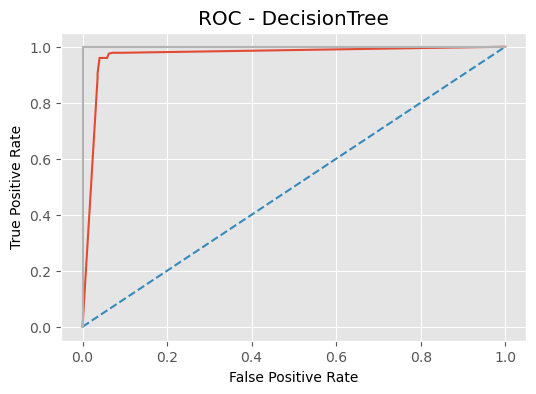

________________________________


In [147]:
X_test_sel = selector.transform(X_test)
decision_tree = DecisionTreeClassifier(min_samples_leaf=6, random_state=78)
decision_tree.fit(X_train_sel, y_train)
y_pred = decision_tree.predict(X_test_sel)

label_encoder = LabelEncoder()
encoded_y_test = label_encoder.fit_transform(y_test)
label_encoder_name_mapping = dict(zip(label_encoder.classes_,
                                        label_encoder.transform(label_encoder.classes_)))
y_score = decision_tree.predict_proba(X_test_sel)
fpr, tpr, _ = roc_curve(encoded_y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}' )
print(f'F1-score: {f1_score(y_test, y_pred, average=None)}')
print(classification_report(y_test, y_pred, digits=3))
print('ROC Curve:', roc_auc)
plt.subplots(1, figsize=(6,4))
plt.title('ROC - DecisionTree')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print('________________________________')

In [148]:
print(df_RFE.shape)
df_RFE.head()

(2452, 17)


,emotion_disgust,frame_count,sc_max,sc_q25,sc_q50,kur_w1,sc_kur_w1,stft_kur_w1,mfcc_kur_w2,sc_mean_w2,sc_q25_w2,mfcc_q05_w3,mfcc_kur_w3,kur_w4,zc_sum_w4,sc_min_w4,vocal_channel
0,0,0.106792,0.705391,0.560393,0.927656,0.572236,0.692039,0.503824,0.438077,0.405315,0.385595,0.801812,0.481993,0.290004,0.448805,0.000000,speech
1,0,0.116504,0.450510,0.561798,0.799551,0.435323,0.638155,0.192102,0.457699,0.420190,0.394864,0.852725,0.449225,0.339563,0.396224,0.869244,speech
2,0,0.097081,0.459613,0.472504,0.911578,0.100512,0.494276,0.131463,0.540126,0.474156,0.294100,0.820192,0.451288,0.298100,0.361620,0.000000,speech
3,0,0.067960,0.453229,0.537759,0.841966,0.107666,0.055930,0.115819,0.590455,0.556900,0.309099,0.838101,0.441262,0.292879,0.492813,0.871873,speech
4,0,0.174752,0.598407,0.505940,0.733857,0.430345,0.767877,0.615396,0.419206,0.404362,0.351926,0.868720,0.365163,0.293666,0.461552,0.819687,speech


In [149]:
df_RFE.to_csv('data_for_AD', index = False)